# Quora Insincere Questions Classification

## 1. Loading Libraries

In [1]:
!pip install regex eli5 emojic

ERROR: Could not find a version that satisfies the requirement emojic
ERROR: No matching distribution found for emojic


In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import os
import re
import csv
import string
import emoji
import regex
import eli5
import pickle
import gensim
import spacy
import gc
from tqdm import tqdm
import random
import sklearn

import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from scipy.sparse import hstack
from IPython.display import Image
from prettytable import PrettyTable

from tqdm import tqdm_notebook
tqdm_notebook().pandas()

from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer
from nltk.util import ngrams

from sklearn.metrics import confusion_matrix, log_loss
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, classification_report
from sklearn.calibration import CalibratedClassifierCV

0it [00:00, ?it/s]

In [3]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 2. Loading data

In [4]:
df_train = pd.read_csv('../input/quora-insincere-questions-classification/train.csv')
df_test = pd.read_csv('../input/quora-insincere-questions-classification/train.csv')

print("Number of data points in training data:", df_train.shape[0])
print("Number of data points in test data:", df_test.shape[0])

Number of data points in training data: 1306122
Number of data points in test data: 1306122


In [5]:
df_train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [6]:
df_train['question_text'].isnull().sum(), df_test['question_text'].isnull().sum()

(0, 0)

#### Nhận xét: 
Tập dữ liệu huấn luyện gồm các cột: qid, question_text và target (giá trị nhị phân). Tất cả các quan sát là duy nhất với các giá trị khác null.

## 3. Data Analysis

### 3.1 Distribution of data points among output class

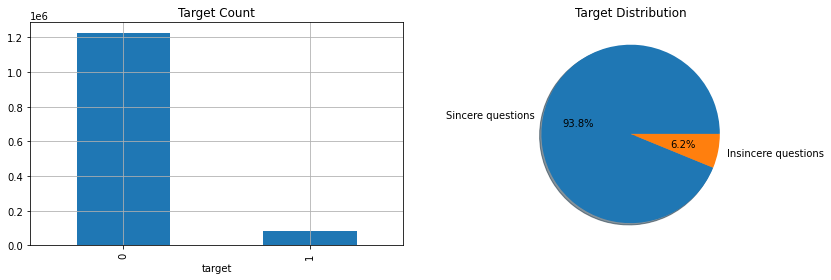

In [7]:
# Bar chart
plt.subplot(1, 2, 1)
df_train.groupby('target')['qid'].count().plot.bar()
plt.grid(True)
plt.title('Target Count')
plt.subplots_adjust(right=1.9)

# Pie Chart
plt.subplot(1, 2, 2)
values = [df_train[df_train['target']==0].shape[0], df_train[df_train['target']==1].shape[0]]
labels = ['Sincere questions', 'Insincere questions']

plt.pie(values, labels=labels, autopct='%1.1f%%', shadow=True)
plt.title('Target Distribution')
plt.tight_layout()
plt.subplots_adjust(right=1.9)
plt.show()

#### Nhận xét: 
- Tập dữ liệu rất mất cân bằng với chỉ 6,2% insincere questions.
- Nên sử dụng F1-score vì sự mất cân bằng trong dữ liệu.

### 3.2 Word cloud for both sincere and insincere questions

In [8]:
def display_wordcloud(data, title):
    words_list = data.unique().tolist()
    words = ' '.join(words_list)
    
    wordcloud = WordCloud(width = 800, height = 400,
                      stopwords = set(STOPWORDS)).generate(words)

    plt.figure(figsize=(20, 12), facecolor=None)
    plt.imshow(wordcloud)
    plt.title(f'Words in {title}')
    plt.axis("off")
    plt.show()

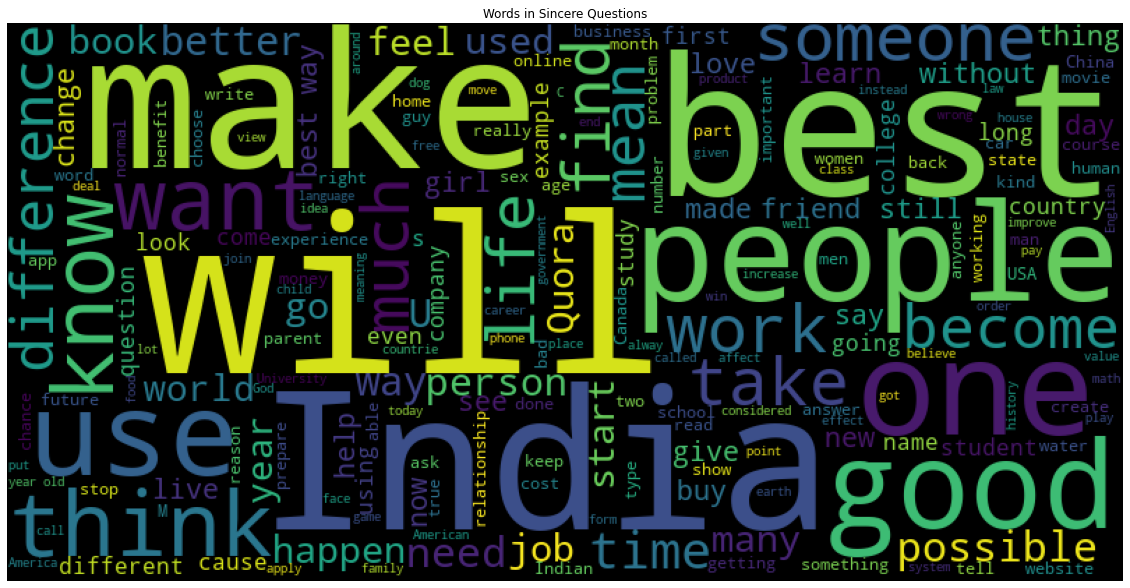

In [9]:
# Wordcloud for Sincere Questions
display_wordcloud(df_train[df_train['target']==0]['question_text'], 'Sincere Questions')

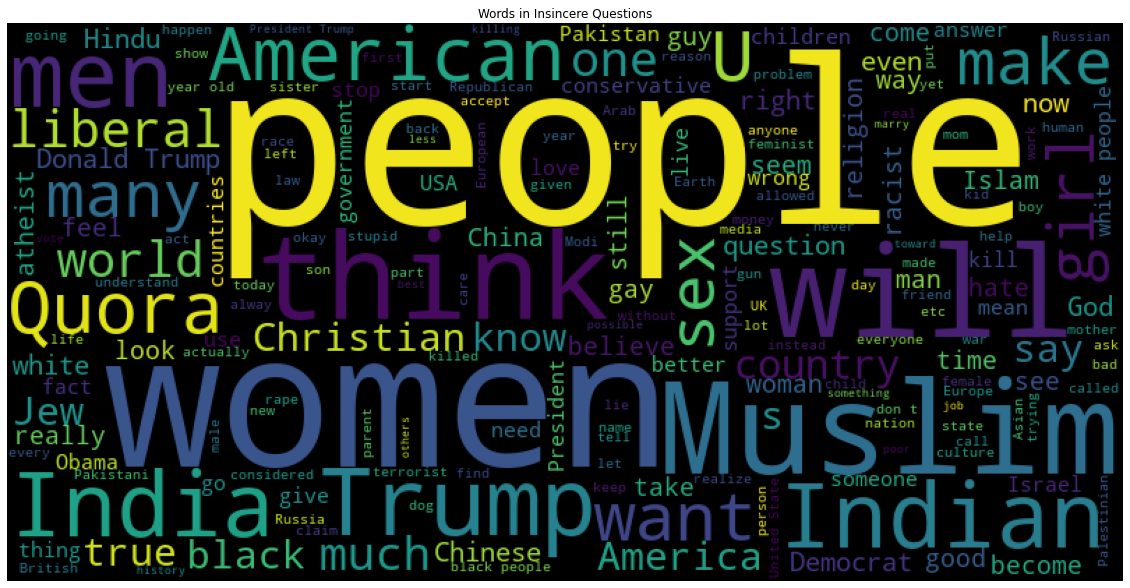

In [10]:
# Wordcloud for Insincere Questions
display_wordcloud(df_train[df_train['target']==1]['question_text'], 'Insincere Questions')

#### Nhận xét:
 - Những câu hỏi thiếu chân thành chứa nhiều từ ngữ xúc phạm.
 - Hầu hết các câu hỏi liên quan đến Con người, Hồi giáo, Phụ nữ, Trump, v.v.

### 3.4 Basic Feature Extraction

#### Vấn đề:  Làm thế nào để có thể phân tích dữ liệu câu hỏi hiệu quả hơn theo từng yếu tố của câu như số từ, số ký tự, số ký tự viết hoa,... để từ đó có thể tìm ra đặc trưng của các câu hỏi sincere và insincere?

#### Giải pháp: 
- Chia các câu thành các từ hay tokenization.

In [11]:
# https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc

# Number of words
df_train['num_words'] = df_train['question_text'].apply(lambda x: len(str(x).split()))
df_test['num_words'] = df_test['question_text'].apply(lambda x: len(str(x).split()))

# Number of capital_letters
df_train['num_capital_let'] = df_train['question_text'].apply(lambda x: len([c for c in str(x) if c.isupper()]))
df_test['num_capital_let'] = df_test['question_text'].apply(lambda x: len([c for c in str(x) if c.isupper()]))

# Number of special characters
df_train['num_special_char'] = df_train['question_text'].str.findall(r'[^a-zA-Z0-9 ]').str.len()
df_test['num_special_char'] = df_test['question_text'].str.findall(r'[^a-zA-Z0-9 ]').str.len()

# Number of unique words
df_train['num_unique_words'] = df_train['question_text'].apply(lambda x: len(set(str(x).split())))
df_test['num_unique_words'] = df_test['question_text'].apply(lambda x: len(set(str(x).split())))

# Number of numerics
df_train['num_numerics'] = df_train['question_text'].apply(lambda x: sum(c.isdigit() for c in x))
df_test['num_numerics'] = df_test['question_text'].apply(lambda x: sum(c.isdigit() for c in x))

# Number of characters
df_train['num_char'] = df_train['question_text'].apply(lambda x: len(str(x)))
df_test['num_char'] = df_test['question_text'].apply(lambda x: len(str(x)))

# Number of stopwords
df_train['num_stopwords'] = df_train['question_text'].apply(lambda x: len([c for c in str(x).lower().split() if c in STOPWORDS]))
df_test['num_stopwords'] = df_test['question_text'].apply(lambda x: len([c for c in str(x).lower().split() if c in STOPWORDS]))

df_train.head()

,qid,question_text,target,num_words,num_capital_let,num_special_char,num_unique_words,num_numerics,num_char,num_stopwords
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,13,2,1,13,4,72,7
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,16,1,2,15,0,81,10
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,10,2,2,8,0,67,3
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,9,4,1,9,0,57,3
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,15,3,1,15,0,77,7


#### Nhận xét:
- Từ đó ta có thể phân tích các câu hỏi theo các đặc trưng mã được tokenization

### 3.5 Analysis on extracted features.

In [12]:
print("Minimum length of a question:", min(df_train['num_words']))
print("Maximum length of a question:", max(df_train['num_words']))

Minimum length of a question: 1
Maximum length of a question: 134


In [13]:
def display_boxplot(_x, _y, _data, _title):
    sns.boxplot(x=_x, y=_y, data=_data)
    plt.grid(True)
    plt.title(_title)

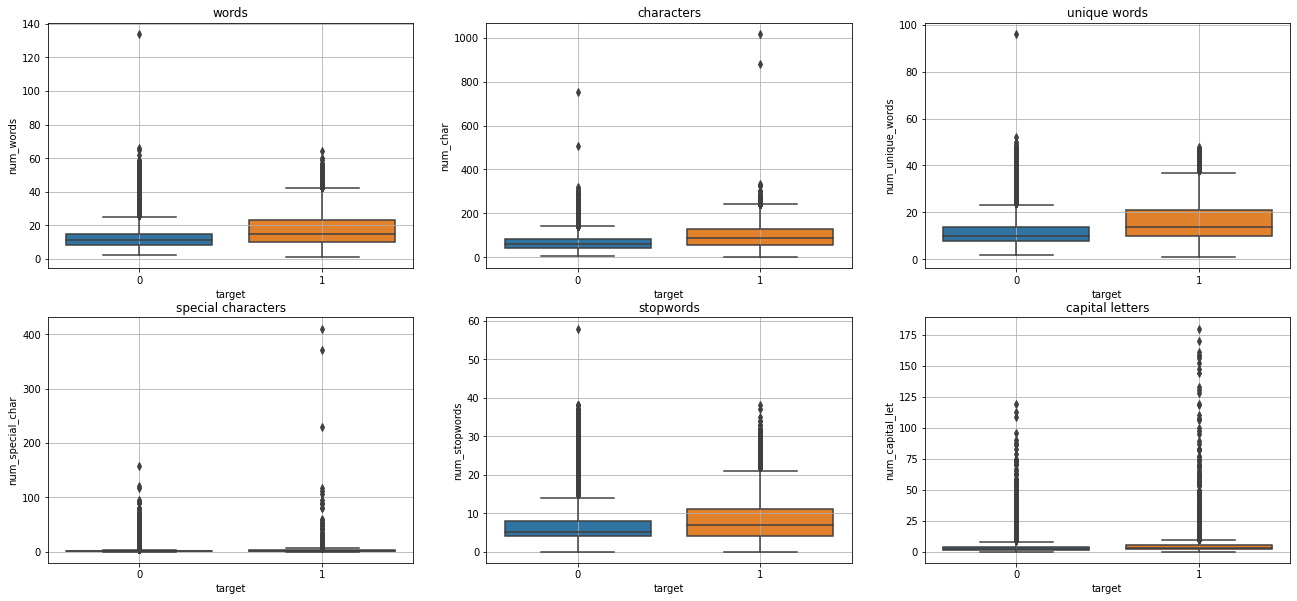

In [14]:
# Boxplot: Number of words
plt.subplot(2, 3, 1)
display_boxplot('target', 'num_words', df_train, 'words')

# Boxplot: Number of chars
plt.subplot(2, 3, 2)
display_boxplot('target', 'num_char', df_train, 'characters')

# Boxplot: Number of unique words
plt.subplot(2, 3, 3)
display_boxplot('target', 'num_unique_words', df_train, 'unique words')

# Boxplot: Number of special characters
plt.subplot(2, 3, 4)
display_boxplot('target', 'num_special_char', df_train, 'special characters')

# Boxplot: Number of stopwords
plt.subplot(2, 3, 5)
display_boxplot('target', 'num_stopwords', df_train, 'stopwords')

# Boxplot: Number of capital letters
plt.subplot(2, 3, 6)
display_boxplot('target', 'num_capital_let', df_train, 'capital letters')


plt.subplots_adjust(right=3.0)
plt.subplots_adjust(top=2.0)
plt.show()

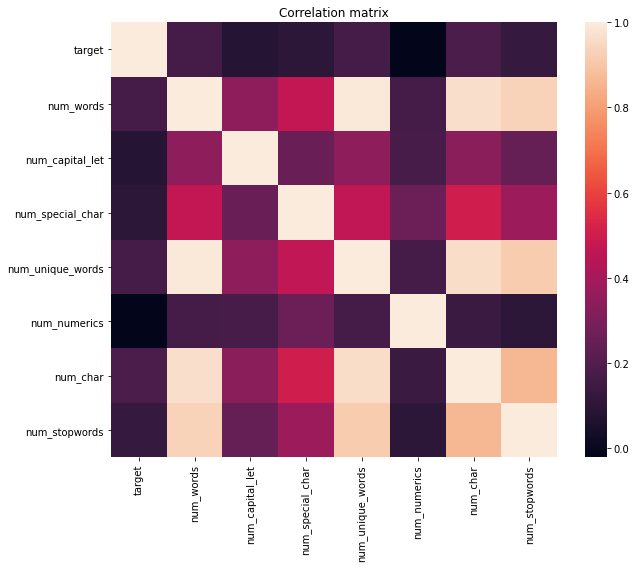

In [15]:
# Correlation matrix
f, ax = plt.subplots(figsize=(10, 8))
corr = df_train.corr()
sns.heatmap(corr, ax=ax)
plt.title("Correlation matrix")
plt.show()

#### Nhận xét:
- Insincere questions có vẻ gồm nhiều từ và ký tự hơn.
- Insincere questions có nhiều unique_words hơn sincere questions.

In [16]:
# Questions with most number of non-alphanumeric characters.
  # Insincere questions are printed in red color.

qids = df_train.sort_values('num_special_char', ascending=False)['qid'].head(20).values
for id in qids:
  row = df_train[df_train['qid'].values == id]
  if row['target'].values[0] == 1: 
    color = '\033[31m'
  else:
    color = '\033[0m'
  print(color, row['question_text'].values[0], '\n')

 What is [math]\frac{\int_{1x^5}^{3x^{-5}} \tan(\tan({\boxed{\int_{1x^0}^{1x^2} \sum_{\varpi=1}^{\infty} \int_{2x^{-3}}^{2x^2} \sum_{\alpha=7}^{\infty} \underbrace{\sqrt[2]{1x^5}}_{\text{Gauss's Law of Theoretical Probability.}} d\tau dx}}^{1x^0})) d\mu}{\int_{2x^{-3}}^{1x^5} \cos(\int_{2x^2}^{1x^{-3}} \frac{\sqrt[2]{\overbrace{\underbrace{\frac{3x^3+3x^5}{\sqrt[3]{2x^{-3}}}}_{\text{Gauss's Law of Theoretical Probability.}} \times \overbrace{\tan(2x^0)}^{\text{Gauss's Law of Theoretical Probability.}}-\sum_{4=7}^{\infty} \boxed{3x^{-5}}}^{\text{Inverse Function.}}}}{{\boxed{\int_{2x^2}^{2x^4} 3x^1 d9} \div \sum_{6=6}^{\infty} \sqrt[3]{2x^2}+\sqrt[4]{\sin(2x^0+3x^0)}}^{2x^{-4}}+\boxed{\frac{\vec{\boxed{\sum_{\gamma=10}^{\infty} 1x^{-5}}}}{\frac{\sum_{\iota=2}^{\infty} 1x^{-5}-\frac{3x^{-1}}{1x^{-4}}}{\sin(\tan(3x^{-2}))}}}} \times \boxed{\sqrt[2]{{{{\sqrt[5]{2x^5}}^{2x^{-1}}}^{2x^{-1}} \div \sum_{\chi=6}^{\infty} \int_{1x^4}^{2x^{-4}} 3x^2 d\vartheta+{2x^{-3}}^{2x^{-5}}}^{3x^{-4}}}} d\m

#### Nhận xét:
- Các câu hỏi về toán học hầu hết đều được phân loại là insincere questions, trong các câu hỏi này thường chứa các ký tự đặc biệt và các chữ số.
- Một số câu hỏi cũng chứa biểu tượng cảm xúc và các ký tự không phải tiếng Anh.
- Sự hiện diện của các dấu chấm câu có thể tăng thêm giá trị cho các mô hình ML.

## 4. Data Preprocessing and cleaning

#### Vấn đề: 
    - Văn bản khi chưa xử lý chứa các ký tự, từ ngữ không có ích cho việc đánh giá đó là câu hỏi sincere or insincere
    - Xử lý văn bản còn giúp cải thiện F1-score

#### Giải pháp:
- Thay thế các phương trình toán học và url bằng cách viết tắt phổ biến.
- Sửa các từ viết tắt.
- Sửa lỗi chính tả.
- Bỏ dấu chấm câu, các kí tự đặc biệt.
- Loại bỏ các stopword.
- Sử dụng WordNet Lemmatizer để chuyển từ về dạng gốc của nó (kiểu teacher, teaches thành teach; best, better thành good,..)

In [17]:
# Replacing math equations and url addresses with tags.
# https://www.kaggle.com/canming/ensemble-mean-iii-64-36
def clean_tag(x):
  if '[math]' in x:
    x = re.sub('\[math\].*?math\]', 'MATH EQUATION', x) #replacing with [MATH EQUATION]
    
  if 'http' in x or 'www' in x:
    x = re.sub('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-?=%.]+', 'URL', x) #replacing with [url]
  return x

In [18]:
# clean_punct
# https://www.kaggle.com/canming/ensemble-mean-iii-64-36

puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', 
        '•', '~', '@', '£', '·', '_', '{', '}', '©', '^', '®', '`', '<', '→', '°', '€', '™', '›', '♥', '←', '×', '§', '″', '′', 
        '█', '…', '“', '★', '”', '–', '●', '►', '−', '¢', '¬', '░', '¡', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', 
        '—', '‹', '─', '▒', '：', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', '¯', '♦', '¤', '▲', '¸', '⋅', '‘', '∞', 
        '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '・', '╦', '╣', '╔', '╗', '▬', '❤', '≤', '‡', '√', '◄', '━', 
        '⇒', '▶', '≥', '╝', '♡', '◊', '。', '✈', '≡', '☺', '✔', '↵', '≈', '✓', '♣', '☎', '℃', '◦', '└', '‟', '～', '！', '○', 
        '◆', '№', '♠', '▌', '✿', '▸', '⁄', '□', '❖', '✦', '．', '÷', '｜', '┃', '／', '￥', '╠', '↩', '✭', '▐', '☼', '☻', '┐', 
        '├', '«', '∼', '┌', '℉', '☮', '฿', '≦', '♬', '✧', '〉', '－', '⌂', '✖', '･', '◕', '※', '‖', '◀', '‰', '\x97', '↺', 
        '∆', '┘', '┬', '╬', '،', '⌘', '⊂', '＞', '〈', '⎙', '？', '☠', '⇐', '▫', '∗', '∈', '≠', '♀', '♔', '˚', '℗', '┗', '＊', 
        '┼', '❀', '＆', '∩', '♂', '‿', '∑', '‣', '➜', '┛', '⇓', '☯', '⊖', '☀', '┳', '；', '∇', '⇑', '✰', '◇', '♯', '☞', '´', 
        '↔', '┏', '｡', '◘', '∂', '✌', '♭', '┣', '┴', '┓', '✨', '\xa0', '˜', '❥', '┫', '℠', '✒', '［', '∫', '\x93', '≧', '］', 
        '\x94', '∀', '♛', '\x96', '∨', '◎', '↻', '⇩', '＜', '≫', '✩', '✪', '♕', '؟', '₤', '☛', '╮', '␊', '＋', '┈', '％', 
        '╋', '▽', '⇨', '┻', '⊗', '￡', '।', '▂', '✯', '▇', '＿', '➤', '✞', '＝', '▷', '△', '◙', '▅', '✝', '∧', '␉', '☭', 
        '┊', '╯', '☾', '➔', '∴', '\x92', '▃', '↳', '＾', '׳', '➢', '╭', '➡', '＠', '⊙', '☢', '˝', '∏', '„', '∥', '❝', '☐', 
        '▆', '╱', '⋙', '๏', '☁', '⇔', '▔', '\x91', '➚', '◡', '╰', '\x85', '♢', '˙', '۞', '✘', '✮', '☑', '⋆', 'ⓘ', '❒', 
        '☣', '✉', '⌊', '➠', '∣', '❑', '◢', 'ⓒ', '\x80', '〒', '∕', '▮', '⦿', '✫', '✚', '⋯', '♩', '☂', '❞', '‗', '܂', '☜', 
        '‾', '✜', '╲', '∘', '⟩', '＼', '⟨', '·', '✗', '♚', '∅', 'ⓔ', '◣', '͡', '‛', '❦', '◠', '✄', '❄', '∃', '␣', '≪', '｢', 
        '≅', '◯', '☽', '∎', '｣', '❧', '̅', 'ⓐ', '↘', '⚓', '▣', '˘', '∪', '⇢', '✍', '⊥', '＃', '⎯', '↠', '۩', '☰', '◥', 
        '⊆', '✽', '⚡', '↪', '❁', '☹', '◼', '☃', '◤', '❏', 'ⓢ', '⊱', '➝', '̣', '✡', '∠', '｀', '▴', '┤', '∝', '♏', 'ⓐ', 
        '✎', ';', '␤', '＇', '❣', '✂', '✤', 'ⓞ', '☪', '✴', '⌒', '˛', '♒', '＄', '✶', '▻', 'ⓔ', '◌', '◈', '❚', '❂', '￦', 
        '◉', '╜', '̃', '✱', '╖', '❉', 'ⓡ', '↗', 'ⓣ', '♻', '➽', '׀', '✲', '✬', '☉', '▉', '≒', '☥', '⌐', '♨', '✕', 'ⓝ', 
        '⊰', '❘', '＂', '⇧', '̵', '➪', '▁', '▏', '⊃', 'ⓛ', '‚', '♰', '́', '✏', '⏑', '̶', 'ⓢ', '⩾', '￠', '❍', '≃', '⋰', '♋', 
        '､', '̂', '❋', '✳', 'ⓤ', '╤', '▕', '⌣', '✸', '℮', '⁺', '▨', '╨', 'ⓥ', '♈', '❃', '☝', '✻', '⊇', '≻', '♘', '♞', 
        '◂', '✟', '⌠', '✠', '☚', '✥', '❊', 'ⓒ', '⌈', '❅', 'ⓡ', '♧', 'ⓞ', '▭', '❱', 'ⓣ', '∟', '☕', '♺', '∵', '⍝', 'ⓑ', 
        '✵', '✣', '٭', '♆', 'ⓘ', '∶', '⚜', '◞', '்', '✹', '➥', '↕', '̳', '∷', '✋', '➧', '∋', '̿', 'ͧ', '┅', '⥤', '⬆', '⋱', 
        '☄', '↖', '⋮', '۔', '♌', 'ⓛ', '╕', '♓', '❯', '♍', '▋', '✺', '⭐', '✾', '♊', '➣', '▿', 'ⓑ', '♉', '⏠', '◾', '▹', 
        '⩽', '↦', '╥', '⍵', '⌋', '։', '➨', '∮', '⇥', 'ⓗ', 'ⓓ', '⁻', '⎝', '⌥', '⌉', '◔', '◑', '✼', '♎', '♐', '╪', '⊚', 
        '☒', '⇤', 'ⓜ', '⎠', '◐', '⚠', '╞', '◗', '⎕', 'ⓨ', '☟', 'ⓟ', '♟', '❈', '↬', 'ⓓ', '◻', '♮', '❙', '♤', '∉', '؛', 
        '⁂', 'ⓝ', '־', '♑', '╫', '╓', '╳', '⬅', '☔', '☸', '┄', '╧', '׃', '⎢', '❆', '⋄', '⚫', '̏', '☏', '➞', '͂', '␙', 
        'ⓤ', '◟', '̊', '⚐', '✙', '↙', '̾', '℘', '✷', '⍺', '❌', '⊢', '▵', '✅', 'ⓖ', '☨', '▰', '╡', 'ⓜ', '☤', '∽', '╘', 
        '˹', '↨', '♙', '⬇', '♱', '⌡', '⠀', '╛', '❕', '┉', 'ⓟ', '̀', '♖', 'ⓚ', '┆', '⎜', '◜', '⚾', '⤴', '✇', '╟', '⎛', 
        '☩', '➲', '➟', 'ⓥ', 'ⓗ', '⏝', '◃', '╢', '↯', '✆', '˃', '⍴', '❇', '⚽', '╒', '̸', '♜', '☓', '➳', '⇄', '☬', '⚑', 
        '✐', '⌃', '◅', '▢', '❐', '∊', '☈', '॥', '⎮', '▩', 'ு', '⊹', '‵', '␔', '☊', '➸', '̌', '☿', '⇉', '⊳', '╙', 'ⓦ', 
        '⇣', '｛', '̄', '↝', '⎟', '▍', '❗', '״', '΄', '▞', '◁', '⛄', '⇝', '⎪', '♁', '⇠', '☇', '✊', 'ி', '｝', '⭕', '➘', 
        '⁀', '☙', '❛', '❓', '⟲', '⇀', '≲', 'ⓕ', '⎥', '\u06dd', 'ͤ', '₋', '̱', '̎', '♝', '≳', '▙', '➭', '܀', 'ⓖ', '⇛', '▊', 
        '⇗', '̷', '⇱', '℅', 'ⓧ', '⚛', '̐', '̕', '⇌', '␀', '≌', 'ⓦ', '⊤', '̓', '☦', 'ⓕ', '▜', '➙', 'ⓨ', '⌨', '◮', '☷', 
        '◍', 'ⓚ', '≔', '⏩', '⍳', '℞', '┋', '˻', '▚', '≺', 'ْ', '▟', '➻', '̪', '⏪', '̉', '⎞', '┇', '⍟', '⇪', '▎', '⇦', '␝', 
        '⤷', '≖', '⟶', '♗', '̴', '♄', 'ͨ', '̈', '❜', '̡', '▛', '✁', '➩', 'ா', '˂', '↥', '⏎', '⎷', '̲', '➖', '↲', '⩵', '̗', '❢', 
        '≎', '⚔', '⇇', '̑', '⊿', '̖', '☍', '➹', '⥊', '⁁', '✢']

def clean_punct(x):
  x = str(x)
  for punct in puncts:
    if punct in x:
      x = x.replace(punct, ' ')
    return x

In [19]:
# correct_mispell
# https://www.kaggle.com/oysiyl/107-place-solution-using-public-kernel

mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'bitcoin', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization', 
                'electroneum':'bitcoin','nanodegree':'degree','hotstar':'star','dream11':'dream','ftre':'fire','tensorflow':'framework','unocoin':'bitcoin',
                'lnmiit':'limit','unacademy':'academy','altcoin':'bitcoin','altcoins':'bitcoin','litecoin':'bitcoin','coinbase':'bitcoin','cryptocurency':'cryptocurrency',
                'simpliv':'simple','quoras':'quora','schizoids':'psychopath','remainers':'remainder','twinflame':'soulmate','quorans':'quora','brexit':'demonetized',
                'iiest':'institute','dceu':'comics','pessat':'exam','uceed':'college','bhakts':'devotee','boruto':'anime',
                'cryptocoin':'bitcoin','blockchains':'blockchain','fiancee':'fiance','redmi':'smartphone','oneplus':'smartphone','qoura':'quora','deepmind':'framework','ryzen':'cpu','whattsapp':'whatsapp',
                'undertale':'adventure','zenfone':'smartphone','cryptocurencies':'cryptocurrencies','koinex':'bitcoin','zebpay':'bitcoin','binance':'bitcoin','whtsapp':'whatsapp',
                'reactjs':'framework','bittrex':'bitcoin','bitconnect':'bitcoin','bitfinex':'bitcoin','yourquote':'your quote','whyis':'why is','jiophone':'smartphone',
                'dogecoin':'bitcoin','onecoin':'bitcoin','poloniex':'bitcoin','7700k':'cpu','angular2':'framework','segwit2x':'bitcoin','hashflare':'bitcoin','940mx':'gpu',
                'openai':'framework','hashflare':'bitcoin','1050ti':'gpu','nearbuy':'near buy','freebitco':'bitcoin','antminer':'bitcoin','filecoin':'bitcoin','whatapp':'whatsapp',
                'empowr':'empower','1080ti':'gpu','crytocurrency':'cryptocurrency','8700k':'cpu','whatsaap':'whatsapp','g4560':'cpu','payymoney':'pay money',
                'fuckboys':'fuck boys','intenship':'internship','zcash':'bitcoin','demonatisation':'demonetization','narcicist':'narcissist','mastuburation':'masturbation',
                'trignometric':'trigonometric','cryptocurreny':'cryptocurrency','howdid':'how did','crytocurrencies':'cryptocurrencies','phycopath':'psychopath',
                'bytecoin':'bitcoin','possesiveness':'possessiveness','scollege':'college','humanties':'humanities','altacoin':'bitcoin','demonitised':'demonetized',
                'brasília':'brazilia','accolite':'accolyte','econimics':'economics','varrier':'warrier','quroa':'quora','statergy':'strategy','langague':'language',
                'splatoon':'game','7600k':'cpu','gate2018':'gate 2018','in2018':'in 2018','narcassist':'narcissist','jiocoin':'bitcoin','hnlu':'hulu','7300hq':'cpu',
                'weatern':'western','interledger':'blockchain','deplation':'deflation', 'cryptocurrencies':'cryptocurrency', 'bitcoin':'blockchain cryptocurrency',}

def correct_mispell(x):
  words = x.split()
  for i in range(0, len(words)):
    if mispell_dict.get(words[i]) is not None:
      words[i] = mispell_dict.get(words[i])
    elif mispell_dict.get(words[i].lower()) is not None:
      words[i] = mispell_dict.get(words[i].lower())
        
  words = " ".join(words)
  return words

In [20]:
# remove stopwords
def remove_stopwords(x):
  x = [word for word in x.split() if word not in STOPWORDS]
  x = ' '.join(x)

  return x

In [21]:
# clean word contractions
## https://www.kaggle.com/theoviel/improve-your-score-with-text-preprocessing-v2 

contraction_mapping = {"We'd": "We had", "That'd": "That had", "AREN'T": "Are not", "HADN'T": "Had not", "Could've": "Could have", "LeT's": "Let us", "How'll": "How will", "They'll": "They will", "DOESN'T": "Does not", "HE'S": "He has", "O'Clock": "Of the clock", "Who'll": "Who will", "What'S": "What is", "Ain't": "Am not", "WEREN'T": "Were not", "Y'all": "You all", "Y'ALL": "You all", "Here's": "Here is", "It'd": "It had", "Should've": "Should have", "I'M": "I am", "ISN'T": "Is not", "Would've": "Would have", "He'll": "He will", "DON'T": "Do not", "She'd": "She had", "WOULDN'T": "Would not", "She'll": "She will", "IT's": "It is", "There'd": "There had", "It'll": "It will", "You'll": "You will", "He'd": "He had", "What'll": "What will", "Ma'am": "Madam", "CAN'T": "Can not", "THAT'S": "That is", "You've": "You have", "She's": "She is", "Weren't": "Were not", "They've": "They have", "Couldn't": "Could not", "When's": "When is", "Haven't": "Have not", "We'll": "We will", "That's": "That is", "We're": "We are", "They're": "They' are", "You'd": "You would", "How'd": "How did", "What're": "What are", "Hasn't": "Has not", "Wasn't": "Was not", "Won't": "Will not", "There's": "There is", "Didn't": "Did not", "Doesn't": "Does not", "You're": "You are", "He's": "He is", "SO's": "So is", "We've": "We have", "Who's": "Who is", "Wouldn't": "Would not", "Why's": "Why is", "WHO's": "Who is", "Let's": "Let us", "How's": "How is", "Can't": "Can not", "Where's": "Where is", "They'd": "They had", "Don't": "Do not", "Shouldn't":"Should not", "Aren't":"Are not", "ain't": "is not", "What's": "What is", "It's": "It is", "Isn't":"Is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }

def clean_contractions(text):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    
    text = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in text.split(" ")])
    return text

In [22]:
# word lemmatizing

lemmatizer = WordNetLemmatizer()
def lemma_text(x):
  x = x.split()
  x = [lemmatizer.lemmatize(word) for word in x]
  x = ' '.join(x)

  return x

In [23]:
def data_cleaning(x):
  x = clean_tag(x)
  x = clean_punct(x)
  x = correct_mispell(x)
  x = remove_stopwords(x)
  x = clean_contractions(x)
  x = lemma_text(x)
  return x

In [24]:
# preprocessing given train and test data
df_train['preprocessed_question_text'] = df_train['question_text'].progress_map(lambda x: data_cleaning(x))
df_test['preprocessed_question_text'] = df_test['question_text'].progress_map(lambda x: data_cleaning(x))

  0%|          | 0/1306122 [00:00<?, ?it/s]

  0%|          | 0/1306122 [00:00<?, ?it/s]

#### Kết quả: Dữ liệu sau khi được làm sạch 
#### Dữ liệu sau khi được làm sạch sẽ dử dụng TF-IDF để vector hóa rồi đưa vào model để train

## 5. Train, Test & Val split


Chia data Train ra thành 2 phần: Train và Val (Tập Test không có target nên phải cần 1 tập khác để kiểm tra máy đang học đúng hay sai)

In [25]:
y = df_train['target'].values
X_train, X_test, y_train, y_test = train_test_split(df_train, y, test_size=0.2, random_state=2019)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=2019)

print('X_train: ', X_train.shape, y_train.shape)
print('X_test: ',X_test.shape, y_test.shape)
print('X_val: ',X_val.shape, y_val.shape)

X_train:  (940407, 11) (940407,)
X_test:  (261225, 11) (261225,)
X_val:  (104490, 11) (104490,)


In [26]:
# check for percentage of class disb in train test split.

def plot_class_disb(class_disb, data, disb_name):
  class_disb.plot(kind="bar")
  plt.xlabel('class')
  plt.ylabel('Datapoints per class')
  plt.title(f'Distribution of yi in {disb_name}')
  plt.grid(True)
  
  sorted_yi = np.argsort(-class_disb.values)
  print(disb_name,':')
  for i in sorted_yi:
    print('Number of data points in class', i, ':', class_disb.values[i], '(', np.round((class_disb.values[i]/data.shape[0]*100), 3), '%)')
  
  print('-'*50)

Kiểm tra xem các class ở trong các file có cân bằng không. Tránh các trường hợp kiểu chia xong file train vs val mà train chỉ gồm mỗi 1 class hay val chỉ có mỗi 1 class

TRAIN :
Number of data points in class 1 : 882455 ( 93.838 %)
Number of data points in class 0 : 57952 ( 6.162 %)
--------------------------------------------------
TEST :
Number of data points in class 1 : 244934 ( 93.764 %)
Number of data points in class 0 : 16291 ( 6.236 %)
--------------------------------------------------
VAILIDATION :
Number of data points in class 1 : 97923 ( 93.715 %)
Number of data points in class 0 : 6567 ( 6.285 %)
--------------------------------------------------


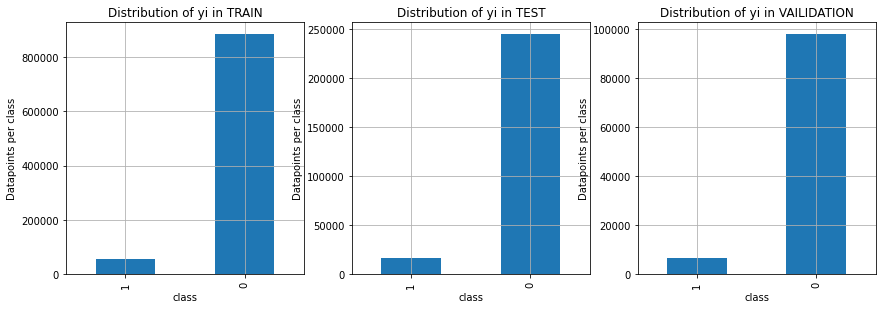

In [27]:
# distribution of yi in train, test and val

plt.subplot(1, 3, 1)
plot_class_disb(
  X_train['target'].value_counts().sort_values(),
  X_train,
  'TRAIN')
         
plt.subplot(1, 3, 2)
plot_class_disb(
  X_test['target'].value_counts().sort_values(),
  X_test,
  'TEST')

plt.subplot(1, 3, 3)
plot_class_disb(
  X_val['target'].value_counts().sort_values(),
  X_val,
  'VAILIDATION')
plt.subplots_adjust(right=2.0)
plt.subplots_adjust(top=1)
plt.show()

### Nhận xét: Các class ở các file phân bố cân bằng nhau

## 6. Baseline Model(LR) with basic extracted features

In [28]:
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 3))
tfidf.fit_transform(list(df_train['preprocessed_question_text'].values) + list(df_test['preprocessed_question_text'].values))

X_train_ques = tfidf.transform(X_train['preprocessed_question_text'].values)
X_test_ques = tfidf.transform(X_test['preprocessed_question_text'].values)
X_val_ques = tfidf.transform(X_val['preprocessed_question_text'].values)

print(X_train_ques.shape)
print(X_test_ques.shape)
print(X_val_ques.shape)

(940407, 8115931)
(261225, 8115931)
(104490, 8115931)


#### Kết quả: 
- TF-IDF đưa các text đã được preprocess về dạng vector . 
- Output của TF-IDF là ma trận trọng số của các word trong text. Chiều thứ nhất là số dòng (số data), chiều thứ 2 là độ dài vector sau khi chuyển từ text sang.

In [29]:
# Standardize stats features
from sklearn.preprocessing import StandardScaler

# number of words
num_words =  StandardScaler()
X_train_num_words = num_words.fit_transform(X_train['num_words'].values.reshape(-1, 1))
X_test_num_words = num_words.transform(X_test['num_words'].values.reshape(-1, 1))
X_val_num_words = num_words.transform(X_val['num_words'].values.reshape(-1, 1))

# number of unique words
num_unique_words =  StandardScaler()
X_train_num_unique_words = num_unique_words.fit_transform(X_train['num_unique_words'].values.reshape(-1, 1))
X_test_num_unique_words = num_unique_words.transform(X_test['num_unique_words'].values.reshape(-1, 1))
X_val_num_unique_words = num_unique_words.transform(X_val['num_unique_words'].values.reshape(-1, 1))

# number of char
num_char =  StandardScaler()
X_train_num_char = num_char.fit_transform(X_train['num_char'].values.reshape(-1, 1))
X_test_num_char = num_char.transform(X_test['num_char'].values.reshape(-1, 1))
X_val_num_char = num_char.transform(X_val['num_char'].values.reshape(-1, 1))

# number of stopwords
num_stopwords =  StandardScaler()
X_train_num_stopwords = num_stopwords.fit_transform(X_train['num_stopwords'].values.reshape(-1, 1))
X_test_num_stopwords = num_stopwords.transform(X_test['num_stopwords'].values.reshape(-1, 1))
X_val_num_stopwords = num_stopwords.transform(X_val['num_stopwords'].values.reshape(-1, 1))

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
Link StandardScaler, cái này sẽ chuẩn hoá cácma trận tfidf về range từ (-1, 1)

In [30]:
# Stacking features 

X_tr = hstack((
    X_train_ques,
    X_train_num_words,
    X_train_num_unique_words,
    X_train_num_char,
    X_train_num_stopwords
))

X_te = hstack((
    X_test_ques,
    X_test_num_words,
    X_test_num_unique_words,
    X_test_num_char,
    X_test_num_stopwords
))

X_cv = hstack((
    X_val_ques,
    X_val_num_words,
    X_val_num_unique_words,
    X_val_num_char,
    X_val_num_stopwords
))

print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)
print(X_cv.shape, y_val.shape)

(940407, 8115935) (940407,)
(261225, 8115935) (261225,)
(104490, 8115935) (104490,)


In [31]:
parmas = {'C': [0.001, 0.001, 0.1, 1, 10]}

gridsearch = GridSearchCV(LogisticRegression(), parmas, scoring='f1', n_jobs=-1, verbose=1)
gridsearch.fit(X_tr, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.001, 0.1, 1, 10]}, scoring='f1',
             verbose=1)

In [32]:
gridsearch.best_params_

{'C': 10}

In [33]:
clf = LogisticRegression(C=1)
clf.fit(X_tr, y_train)

LogisticRegression(C=1)

In [34]:
y_pred_val = clf.predict_proba(X_cv)[:,1]

for t in np.arange(0.1, 0.201, 0.01):
  t = np.round(t, 2)
  print('F1 score at threshold {0} is {1}'.format(t, f1_score(y_val, (y_pred_val>t).astype('int'))))

F1 score at threshold 0.1 is 0.526587925178689
F1 score at threshold 0.11 is 0.5369113279592703
F1 score at threshold 0.12 is 0.5460879181642245
F1 score at threshold 0.13 is 0.5541891736582001
F1 score at threshold 0.14 is 0.5591742302900873
F1 score at threshold 0.15 is 0.5640868767207097
F1 score at threshold 0.16 is 0.5661042558549484
F1 score at threshold 0.17 is 0.5670289855072463
F1 score at threshold 0.18 is 0.5671820051755025
F1 score at threshold 0.19 is 0.5681864510430115
F1 score at threshold 0.2 is 0.5670727462582665


In [35]:
t = 0.17
y_pred_test = clf.predict_proba(X_te)[:,1]
print('F1-Score: ', round(f1_score(y_test, (y_pred_test>t)), 5))

F1-Score:  0.56643


In [36]:
def plot_confusion_matrix(y_test, y_pred):
  cm = confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(5, 3))
  sns.heatmap(cm, annot=True, fmt='d')
  plt.title('Confusion Matrix')
  plt.show()
  
  print(f"Correctly classified sincere questions: {round(cm[0][0]/(cm[0][0] + cm[0][1])*100, 2)}%")
  print(f"Correctly classified insincere questions: {round(cm[1][1]/(cm[1][0] + cm[1][1])*100, 2)}%")

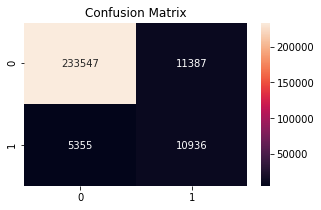

Correctly classified sincere questions: 95.35%
Correctly classified insincere questions: 67.13%


In [37]:
plot_confusion_matrix(y_test, (y_pred_test>t))

### Nhận xét:

In [38]:
print(classification_report(y_test, (y_pred_test>t)))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97    244934
           1       0.49      0.67      0.57     16291

    accuracy                           0.94    261225
   macro avg       0.73      0.81      0.77    261225
weighted avg       0.95      0.94      0.94    261225



In [39]:
eli5.show_weights(clf, vec=tfidf, top=50, feature_filter=lambda x:x != '<BIAS>')

Weight?,Feature
+15.872,democrats
+14.070,liberal
+13.282,woman
+13.040,fuck
+13.032,jews
+12.540,trump
+12.282,rape
+12.184,feminist
+12.087,stupid
+11.957,obama


In [40]:
def display_incorrect_predictions(data, pred):
  """
  Displays text for both correct|incorrect pred for classes(0, 1)
  """
  
  df_classified = data.copy()
  df_classified['pred'] = (pred>t)
  
  print('\033[1m'+'Sample Class Prediction Anaylsis')
  print('')
  
  print('\033[1m'+'Sincere question:\033[34m Correct prediction')
  print('\033[0m')
  print(data[(df_classified['pred'] == False) & (df_classified['target'] ==0) & (df_classified['num_words'] <15)]['question_text'].head(5).values)
  print('\033[1m'+'Sincere question:\033[31m Incorrect prediction')
  print('\033[0m')
  print(data[(df_classified['pred'] == True) & (df_classified['target'] ==0) & (df_classified['num_words'] <15)]['question_text'].head(5).values)
  
  print('-'*50)
  
  print('\033[1m'+'Insincere question :\033[34m Correct prediction')
  print('\033[0m')
  print(data[(df_classified['pred'] == True) & (df_classified['target'] ==1) & (df_classified['num_words'] <15)]['question_text'].head(5).values)
  print('\033[1m'+'Insincere question:\033[31m Incorrect Prediction')
  print('\033[0m')
  print(data[(df_classified['pred'] == False) & (df_classified['target'] ==1) & (df_classified['num_words'] <15)]['question_text'].head(5).values)
  

In [41]:
display_incorrect_predictions(X_test, (y_pred_test>t))

Sample Class Prediction Anaylsis

Sincere question: Correct prediction

['Why were kyber crystals used for the Death Stars?'
 'Which country would have the most benefits for a child to be born in?'
 'What can I read to learn methodology?'
 'How do I avoid getting that spinning blue circle pointer thingy in Windows 10?'
 'Why an object is subjected to weightlessness during a free-fall?']
Sincere question: Incorrect prediction

['Why did Hitler executed Jews with gas, ovens, shots, etc if they could work?'
 'Why is a dick so long?'
 'How should liberals respond to lies being told about them?'
 'How do I become fearless against people who are rude to me?'
 'Who thinks they can trump the Trump?']
--------------------------------------------------
Insincere question : Correct prediction

["My IQ is over 160, why don't my classmates treat me with respect?"
 'Had Tywin Lannister ever been castrated?'
 'Why do Israeli Muslims hate Israel and Jewish?'
 'Are Indians planning to genocide Nepali-s

## 7. Prediction

In [42]:
y_pred_res = clf.predict(X_te)
print(len(y_pred_res))

261225


In [43]:
temp = X_test['qid'].to_dict()
qid = []
for (key, val) in temp.items():
    qid.append(val)

In [44]:
print(qid[:4])

['7cdd59f6f0a7d2cdaf98', 'ba2718b956c6abbf3d16', '6ee1622bb3b261b9dda8', 'a92447e568807a216796']


In [45]:
from tqdm import tqdm

pb = tqdm(range(len(y_pred_res)))
res = {}

for i in pb:
    res[qid[i]] = y_pred_res[i]

# print(res)


100%|██████████| 261225/261225 [00:00<00:00, 750611.99it/s]


In [46]:
import csv
with open('submission.csv','w', newline='') as csv_file:
    fieldnames = ['qid', 'prediction']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)

    writer.writeheader()
    for (key, val) in res.items():
        writer.writerow({'qid': key, 'prediction': val})
